<a href="https://colab.research.google.com/github/talmolab/sleap/blob/main/docs/notebooks/Post_inference_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-inference tracking

In tracking, we associate the poses (that were detected within individual frames) across time such that they belong to the same individual.

Since we typically do this separately, it is sometimes desirable to tweak the tracking parameters to optimize accuracy without having to re-run inference (e.g., `sleap-track`).

In this notebook, we will explore how to re-run the tracking given an existing predictions SLP file.

**Note:** Tracking does not run on the GPU, so this notebook can be run locally on your computer without the hassle of uploading your data if desired.

## 1. Setup SLEAP

Run this cell first to install SLEAP. If you get a dependency error in subsequent cells, just click **Runtime** → **Restart runtime** to reload the packages.


### Install

In [1]:
# This should take care of all the dependencies on colab:
!pip uninstall -qqq -y opencv-python opencv-contrib-python
!pip install -qqq "sleap[pypi]>=1.3.3"

# But to do it locally, we'd recommend the conda package (available on Windows + Linux):
# conda create -n sleap -c sleap -c conda-forge -c nvidia sleap

### Test

In [2]:
#@title SLEAP and system versions: { display-mode: "form" }
import sleap
sleap.versions()
sleap.system_summary()

2023-09-01 14:17:16.250591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/talmolab/micromamba/envs/sleap_jupyter/lib/python3.7/site-packages/cv2/../../lib64:/home/talmolab/micromamba/envs/sleap_jupyter/lib:
2023-09-01 14:17:16.250602: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


SLEAP: 1.3.1
TensorFlow: 2.8.4
Numpy: 1.21.6
Python: 3.7.12
OS: Linux-5.15.0-78-generic-x86_64-with-debian-bookworm-sid
GPUs: None detected.


2023-09-01 14:17:17.389239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 14:17:17.390139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/talmolab/micromamba/envs/sleap_jupyter/lib/python3.7/site-packages/cv2/../../lib64:/home/talmolab/micromamba/envs/sleap_jupyter/lib:
2023-09-01 14:17:17.390188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/talmolab/micromamba/envs/sleap_jupyter/lib/python3.7/site-packages/cv2/../../lib64:/home/talmolab/micromamba/envs/sleap_jupyter/lib:
2023-09-01

# 2. Setup data
Here we're downloading an existing `.slp` file with predictions and the corresponding `.mp4` video.

You should replace this with Google Drive mounting if running this on Google Colab, or simply skip it altogether and just set the paths below if running locally.

In [3]:
!wget -q -O fly_clip.mp4 https://github.com/talmolab/sleap-tutorial-uo/blob/main/data/fly_clip.mp4?raw=true
!wget -q -O predictions.slp https://github.com/talmolab/sleap-tutorial-uo/blob/main/data/predictions.slp?raw=true

In [4]:
PREDICTIONS_FILE = "predictions.slp"

# 3. Track

In [5]:
# Load predictions
labels = sleap.load_file(PREDICTIONS_FILE)

# Here I'm removing the tracks so we just have instances without any tracking applied.
for instance in labels.instances():
    instance.track = None
labels.tracks = []
labels

Labels(labeled_frames=1350, videos=1, skeletons=1, tracks=0)

Here we create a tracker with the options we want to experiment with. You can [read more about tracking in the documentation](https://sleap.ai/guides/proofreading.html#tracking-methods) or the parameters in the [`sleap-track` CLI help](https://sleap.ai/guides/cli.html#sleap-track).

In [6]:
# Create tracker
tracker = sleap.nn.tracking.Tracker.make_tracker_by_name(
    # General tracking options
    tracker="flow",
    track_window=3,

    # Matching options
    similarity="instance",
    match="greedy",
    min_new_track_points=1,
    min_match_points=1,

    # Optical flow options (only applies to "flow" tracker)
    img_scale=0.5,
    of_window_size=21,
    of_max_levels=3,

    # Pre-tracking filtering options
    target_instance_count=2,
    pre_cull_to_target=True,
    pre_cull_iou_threshold=0.8,

    # Post-tracking filtering options
    post_connect_single_breaks=True,
    clean_instance_count=0,
    clean_iou_threshold=None,
)

Next we'll actually run the tracking on each frame. This might take a bit longer when using the `"flow"` method.

In [7]:
tracked_lfs = []
for lf in labels:
    lf.instances = tracker.track(lf.instances, img=lf.image)
    tracked_lfs.append(lf)
tracked_labels = sleap.Labels(tracked_lfs)
tracked_labels

Labels(labeled_frames=1350, videos=1, skeletons=1, tracks=2)

# 4. Inspect and save

Let's see the results and save out the tracked predictions.

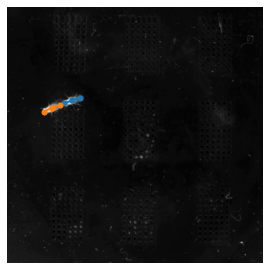

In [8]:
tracked_labels[0].plot(scale=0.25)

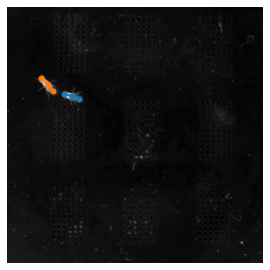

In [9]:
tracked_labels[100].plot(scale=0.25)

In [10]:
tracked_labels.save("retracked.slp")